# 5. Свои данные (___3 балла + бонусы___)

В этой части необходимо выполнить следующее:

1. **Создание датасетов**  
   * Соберите один или пару небольших датасета (минимум 100 примеров, но чем больше, тем лучше).  
   * Дайте волю фантазии, но избегайте неадекватного контента, объема данных или данных за рамками норм.  

2. **Обучение CycleGAN**  
   * Обучите модель CycleGAN для преобразования между вашим датасетом (**домен A**) и другим датасетом (**домен B**).  
   * Второй датасет может быть вашим собственным или любым существующим  

3. **Требования к сдаче**  
   * **Архив с датасетами**:  
     Приложите ссылку на заархивированные данные или загрузите сам архив с данными, использованные для обучения.  
   * **Jupyter Notebook**:  
     * Визуализируйте примеры из доменов A и B с кратким описанием идеи (например, "преобразование эскизов в цветные рисунки").  
     * Добавьте код обучения модели (архитектура, гиперпараметры, функция потерь).  
     * Покажите результаты работы модели (минимум по 5 примеров преобразований A→B и B→A).  
   * **Hugging Face Space + Streamlit**:  
     * Разработайте интерактивное приложение с использованием Streamlit, которое позволяет:  
       - Загружать изображения из доменов A и B.  
       - Отображать результаты преобразований (A→B и B→A) в реальном времени.  
     * Выложите приложение в Hugging Face Space и приложите ссылку на него.  
     * Убедитесь, что модель интегрирована в приложение, а проверяющие могут самостоятельно тестировать её через интерфейс.  

4. **Критерии оценки**  
   * Дополнительные баллы начисляются за:  
     - Креативные и качественные датасеты.  
     - Высокое качество преобразований (четкость, сохранение структуры, отсутствие артефактов).  
     - Удобный и наглядный интерфейс Streamlit-приложения.  

**Примеры идей для датасетов**:  
- Эскизы → Реалистичные изображения.  
- Дневные фото → Ночные фото.  
- Картины в стиле импрессионизма → фотореализм.  

**Важно**:  
- Проверяющий будет оценивать работу через ваше Streamlit-приложение. Убедитесь, что инференс работает стабильно.  
- Если модель слишком велика для деплоя, используйте оптимизацию.  

___Удачи!___ 🚀

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms as tr

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Для тёмной темы jupyter - уберите если не нужно
plt.style.use('dark_background')

from tqdm.auto import tqdm, trange

import os
import sys
import requests
import cv2

from dataclasses import dataclass

# 1. Подготовка данных (___2 балла___)

## 1.1 Выбор и скачивание датасета

In [41]:
import os
os.listdir("data/diamonds_bw_256")

['train_A', 'test_A', 'test_B', 'train_B']

Dataset 'diamonds_bw_256'
Provided splits: ['train_A', 'test_A', 'test_B', 'train_B']
Split 'test_A' of dataset 'diamonds_bw_256' --> size: 26


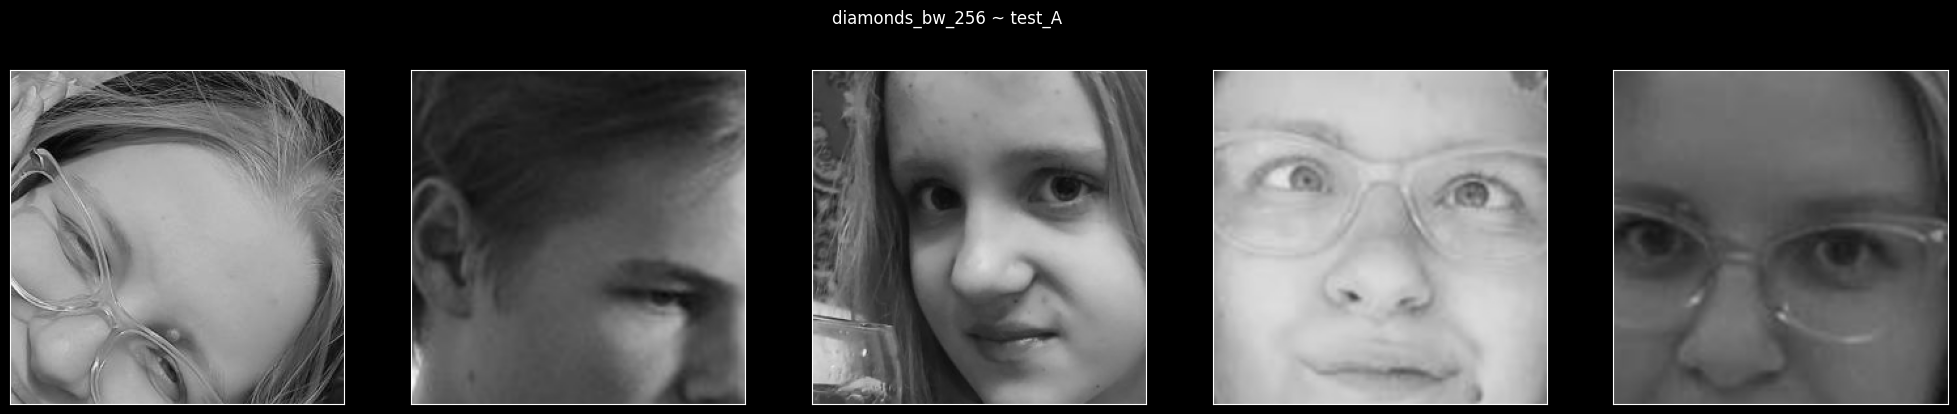

Split 'test_B' of dataset 'diamonds_bw_256' --> size: 26


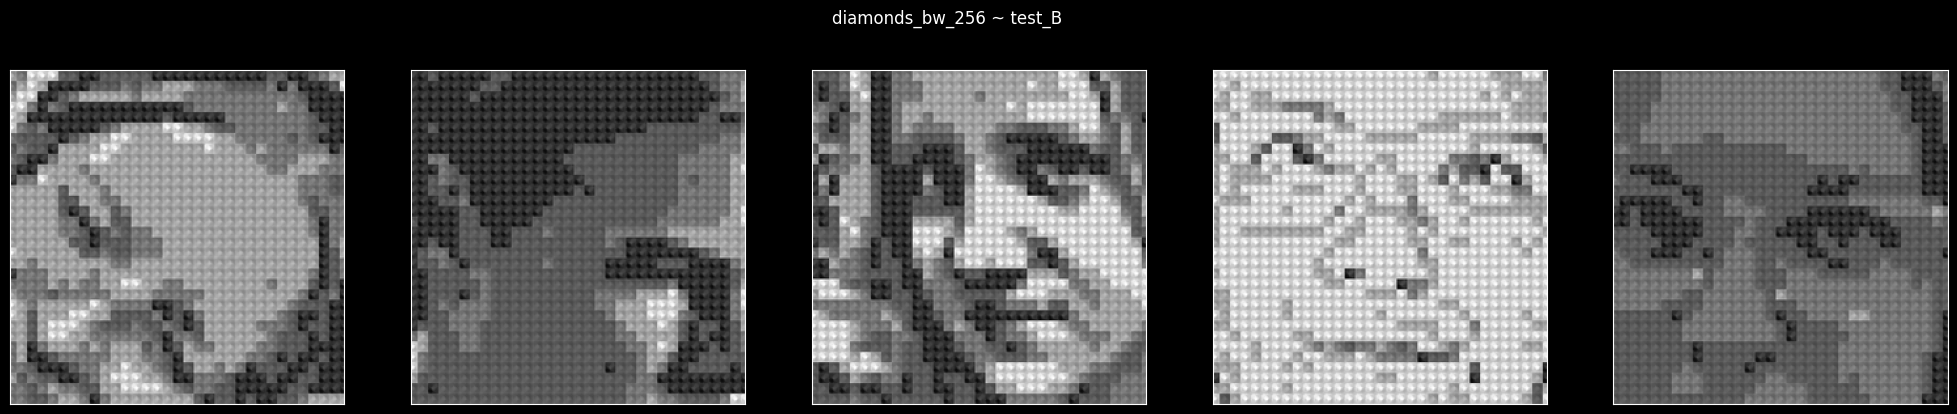

Split 'train_A' of dataset 'diamonds_bw_256' --> size: 90


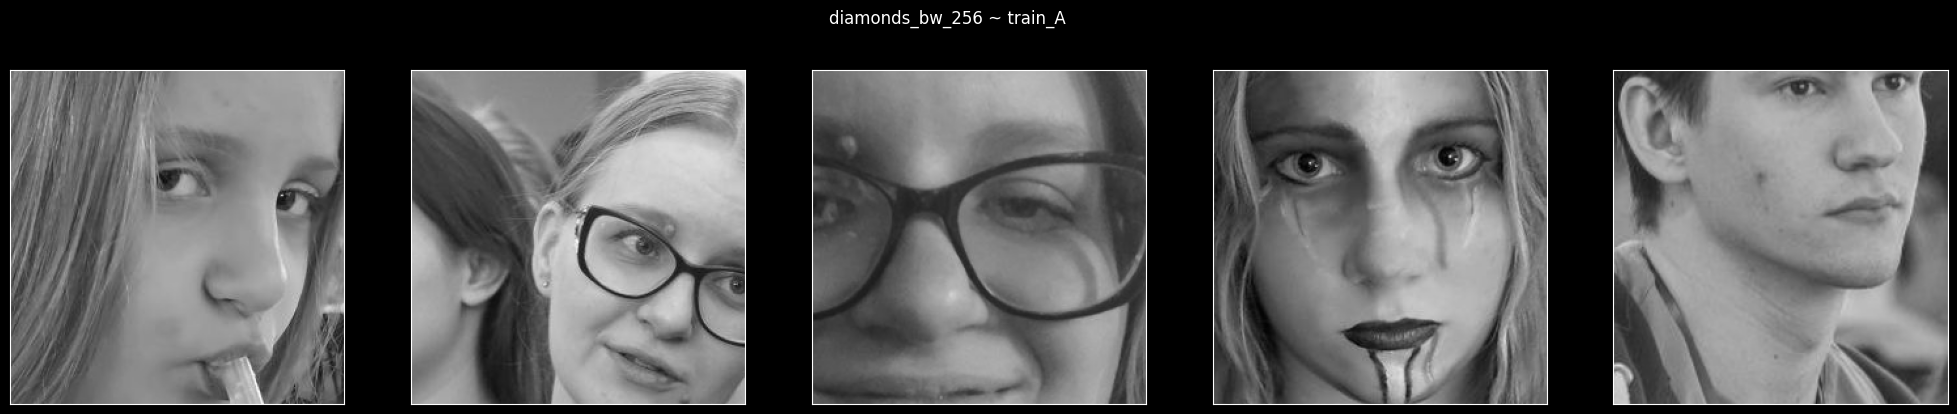

Split 'train_B' of dataset 'diamonds_bw_256' --> size: 90


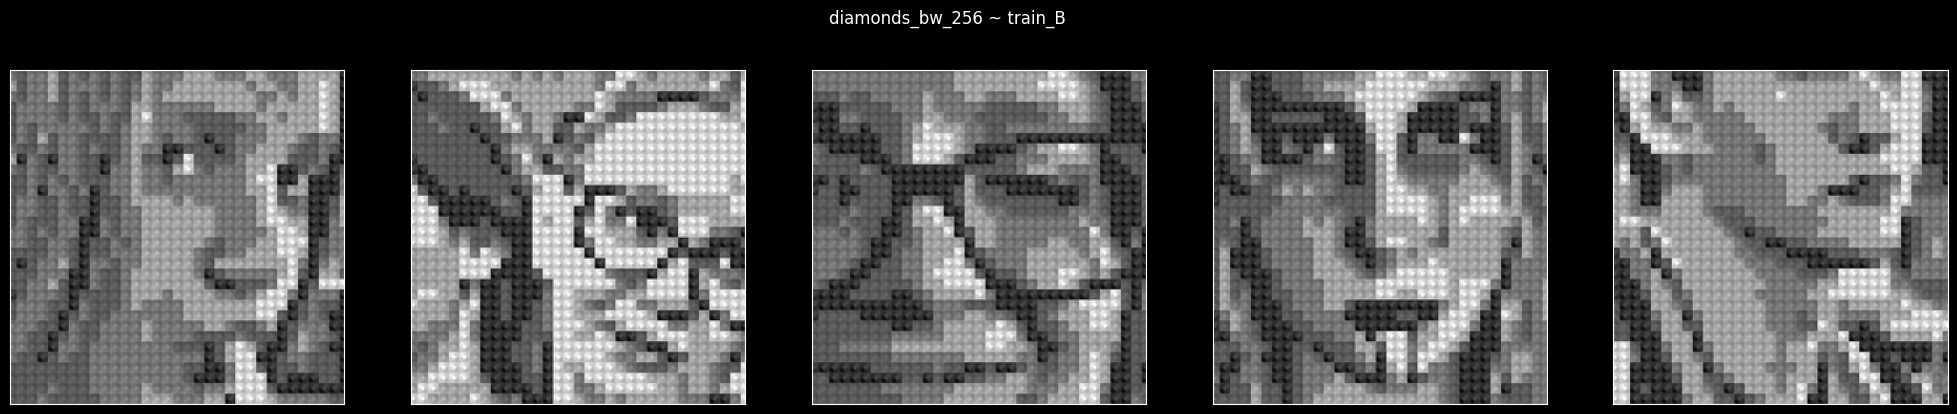


----------------------------



In [42]:
dataset_folder = "data"
num_images_per_split = 5

for dataset_name in [
    "diamonds_bw_256"
]:
    print(f"Dataset '{dataset_name}'")
    target_folder = os.path.join(dataset_folder, dataset_name)

    # Meta + Отрисовка
    print(f"Provided splits: {os.listdir(target_folder)}")
    dataset = datasets.ImageFolder(target_folder)

    inds_to_show = {i: [] for i, _ in enumerate(dataset.classes)}
    classes_full = 0
    for dataset_ind in range(len(dataset)):
        _, split_ind = dataset[dataset_ind]
        if len(inds_to_show[split_ind]) == num_images_per_split:
            continue
        inds_to_show[split_ind].append(dataset_ind)
        if len(inds_to_show[split_ind]) == num_images_per_split:
            classes_full += 1
        if classes_full == len(dataset.classes):
            break

    for split_name in sorted(dataset.classes):
        split_ind = dataset.class_to_idx[split_name]
        print(f"Split '{split_name}' of dataset '{dataset_name}'", end="")
        split_folder = os.path.join(target_folder, split_name)
        print(f" --> size: {len(os.listdir(split_folder))}")

        plt.subplots(1, num_images_per_split, figsize=(5 * num_images_per_split, 5))
        plt.suptitle(f"{dataset_name} ~ {split_name}", y=0.95)
        for i, dataset_ind in enumerate(inds_to_show[split_ind]):
            plt.subplot(1, num_images_per_split, i + 1)
            plt.imshow(dataset[dataset_ind][0])
            plt.xticks([])
            plt.yticks([])
        plt.show()

    print("\n----------------------------\n")

## 1.2 Dataset и Transforms

В папке `target_folder` находятся несколько папок со сплитами для соответствующего датасета, в каждой папке сплита находятся сами `.jpg` изображения.

Давайте составим их в удобном для нас виде в отдельные датасеты для каждого сплита без лэйблов.

Для получения картинок можно использовать
```python
cv2.imread(img_path)[:, :, ::-1]  # каналы записаны в обратном порядке
```

In [43]:
# Выбранный выше и скачанный датасет
dataset_folder = "data"
dataset_name = "diamonds_bw_256"
target_folder = os.path.join(dataset_folder, dataset_name)

# Класс для датасета изображений без лэйблов с применением трансформов
class ImageDatasetNoLabel(Dataset):
    def __init__(self, data_dir, transforms=None):
        super(ImageDatasetNoLabel).__init__()
        self.data_path = data_dir
        self.transform = transforms
        self.data = []

        for path, dir_name, file_name in os.walk(data_dir):
            for name in file_name:
                raw_img = cv2.imread(f'{path}/{name}')[:, :, ::-1]
                img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
                self.data.append(img)

    def __getitem__(self, index):
        if self.transform is not None:
            return self.transform(self.data[index])
        else:
            return self.data[index]

    def __len__(self):
        return len(self.data)

# Удобный класс для хранения всех наших датасетов
@dataclass
class DatasetsClass:
    train_a: ImageDatasetNoLabel
    train_b: ImageDatasetNoLabel
    test_a: ImageDatasetNoLabel
    test_b: ImageDatasetNoLabel


# Все датасеты без трансформов - чтобы посчитать статистики
ds = DatasetsClass(
    train_a=ImageDatasetNoLabel(os.path.join(target_folder, "train_A")),
    train_b=ImageDatasetNoLabel(os.path.join(target_folder, "train_B")),
    test_a=ImageDatasetNoLabel(os.path.join(target_folder, "test_A")),
    test_b=ImageDatasetNoLabel(os.path.join(target_folder, "test_B")),
)

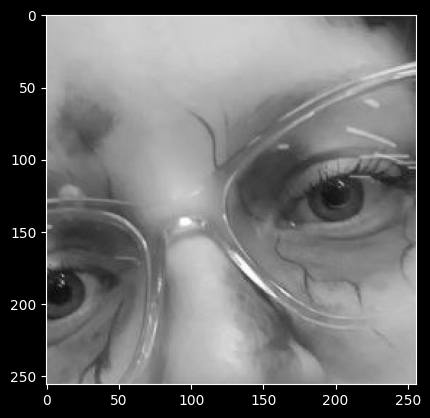

In [45]:
plt.imshow(ds.train_a[0], cmap='gray')

In [46]:
def get_channel_statistics(dataset):
    """
    Функция для получения поканальных статистик (среднее и отклонение) по датасету
    """
    data = np.array(dataset)
    channel_mean = data.mean(axis=(0, 1, 2)) / 255
    channel_std = data.std(axis=(0, 1, 2)) / 255
    return channel_mean, channel_std

# Поканальное среднее и отклонение для A
channel_mean_a, channel_std_a = get_channel_statistics(ds.train_a)
print(channel_mean_a, channel_std_a)

# Поканальное среднее и отклонение для B
channel_mean_b, channel_std_b = get_channel_statistics(ds.train_b)
print(channel_mean_b, channel_std_b)

0.4928711961401314 0.20092090017788686
0.49607503122234137 0.20884467764067952


In [47]:
# Функция для получения train и val transform-ов, а так же функции для де-нормализации изображения
def get_transforms(mean, std):
    train_transform = tr.Compose([
        tr.ToPILImage(),
        tr.Resize((256, 256)),
        tr.ToTensor(),
        tr.Normalize(mean=mean, std=std)
    ])

    val_transform = tr.Compose([
        tr.ToPILImage(),
        tr.Resize((256, 256)),
        tr.ToTensor(),
        tr.Normalize(mean=mean, std=std)
    ])

    def de_normalize(img, normalized=True):
        if normalized:
            img = img.clone().cpu()
            img.mul_(std).add_(mean)
            img = img.numpy().transpose(1, 2, 0)
            img = np.clip(img * 255, 0, 255).astype(np.uint8)
        return img

    return train_transform, val_transform, de_normalize


# Ваши гиперпараметры
hyperparams = dict()

# transform-ы для A и B
train_transform_a, val_transform_a, de_normalize_a = get_transforms(channel_mean_a, channel_std_a, **hyperparams)
train_transform_b, val_transform_b, de_normalize_b = get_transforms(channel_mean_b, channel_std_b, **hyperparams)


# Функция для визуализации transform-ов
def show_examples(dataset, transform, de_norm, num_per_image=3, image_index=0, title=""):
    fig, ax = plt.subplots(1, 1 + num_per_image, figsize=(5 * (1 + num_per_image), 5))

    image = dataset[image_index]

    plt.suptitle(title, y=0.95)

    plt.subplot(1, 1 + num_per_image, 1)
    plt.imshow(image, cmap='gray')
    plt.title("original")

    for i in range(num_per_image):
        plt.subplot(1, 1 + num_per_image, i + 2)
        plt.title(f"#{i}")
        plt.imshow(de_norm(transform(image)), cmap='gray')
    plt.show()

In [48]:
# Все датасеты с трансформами
ds = DatasetsClass(
    train_a=ImageDatasetNoLabel(
        os.path.join(target_folder, "train_A"),
        transforms=train_transform_a,
    ),
    train_b=ImageDatasetNoLabel(
        os.path.join(target_folder, "train_B"),
        transforms=val_transform_b,
    ),
    test_a=ImageDatasetNoLabel(
        os.path.join(target_folder, "test_A"),
        transforms=val_transform_a,
    ),
    test_b=ImageDatasetNoLabel(
        os.path.join(target_folder, "test_B"),
        transforms=val_transform_b,
    ),
)

## 1.3 DataLoader

In [49]:
@dataclass
class DataLoadersClass:
    train_a: DataLoader
    train_b: DataLoader
    test_a: DataLoader
    test_b: DataLoader

batch_size = 15

dataloaders = DataLoadersClass(
    train_a=DataLoader(
        dataset=ds.train_a,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    ),
    train_b=DataLoader(
        dataset=ds.train_b,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    ),
    test_a=DataLoader(
        dataset=ds.test_a,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    ),
    test_b=DataLoader(
        dataset=ds.test_b,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    ),
)

# 2. Модель (___6 баллов___)

## 2.0 Любые вспомогательные модули и классы

In [50]:
pip install segmentation_models_pytorch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [51]:
import segmentation_models_pytorch as smp

## 2.1 Архитектура сети (___3 балла___)

In [52]:
class CycleGAN(nn.Module):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.generator_a2b = smp.Unet(
                                    encoder_name="resnet34",
                                    encoder_weights='imagenet',
                                    in_channels=1,
                                    classes=1,
                                    activation='tanh'
                                ).to(self.device)

        self.generator_b2a = smp.Unet(
                                    encoder_name="resnet34",
                                    encoder_weights='imagenet',
                                    in_channels=1,
                                    classes=1,
                                    activation='tanh'
                                ).to(self.device)

        self.discriminator_a = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        ).to(self.device)

        self.discriminator_b = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        ).to(self.device)

    def forward(self, a, b):
        same_b = self.generator_a2b(b)
        same_a = self.generator_b2a(a)

        # generate fake images
        fake_b = self.generator_a2b(a)
        fake_a = self.generator_b2a(b)

        # generate recovered images (from fakes)
        recovered_a = self.generator_b2a(fake_b)
        recovered_b = self.generator_a2b(fake_a)

        # fake predict
        is_fake_a_pred = F.sigmoid(self.discriminator_a(fake_a))
        is_fake_b_pred = F.sigmoid(self.discriminator_b(fake_b))

        # real predict
        is_real_a_pred = F.sigmoid(self.discriminator_a(a))
        is_real_b_pred = F.sigmoid(self.discriminator_b(b))

        return same_a, same_b, fake_a, fake_b, recovered_a, recovered_b, \
                    is_fake_a_pred, is_fake_b_pred, is_real_a_pred, is_real_b_pred

## 2.2 Loss (___3 балла___)

$$ \mathbf{L}_{\text{cyc}} \big( G_{A \rightarrow B}, G_{B \rightarrow A} \big) = \mathbb{E}_{a \sim A} \bigg( \Big\| G_{B \rightarrow A} \big( G_{A \rightarrow B} ( a ) \big) - a \Big\|_1 \bigg) + \mathbb{E}_{b \sim B} \bigg( \Big\| G_{A \rightarrow B} \big( G_{B \rightarrow A} ( b ) \big) - b \Big\|_1 \bigg) \longrightarrow \min_{G}$$

In [53]:
class CycleConsistencyLoss(nn.Module):
    """
    Функция ошибки, проверяющая что после двойного перехода через генераторы изображение не изменилось
    """
    def __init__(self, reduction='mean'):
        super(CycleConsistencyLoss, self).__init__()
        self.loss_fn = nn.L1Loss(reduction=reduction)

    def forward(self, x, x_rec):
        # Принимает на вход оригинальное изображение и изображение после двойного перехода
        return self.loss_fn(x_rec, x)

$$ \mathbf{L}_{\text{GAN}} \big( G_{A \rightarrow B}, D_{B} \big) = \mathbb{E}_{b \sim B} \log D_{B} (b) + \mathbb{E}_{a \sim A} \log \Big( 1 - D_{B} \big( G_{A \rightarrow B} (a) \big) \Big) \longrightarrow \min_{G} \max_{D}$$

In [54]:
class AdversarialLossCE(nn.Module):
    """
    Стандартная функция ошибки для minmax игры GAN-ов
    """
    def __init__(self, target_real_label=1.0, target_fake_label=0.0):
        super(AdversarialLossCE, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, real_pred, fake_pred=None):
        if fake_pred is None:
            target = self.real_label.expand_as(real_pred)
            return self.loss_fn(real_pred, target)
        else:
            loss_real = self.loss_fn(real_pred, self.real_label.expand_as(real_pred))
            loss_fake = self.loss_fn(fake_pred, self.fake_label.expand_as(fake_pred))
            return loss_real + loss_fake


$$ \mathbb{E}_{b \sim B} \big( D_{B} (b) - 1 \big)^2 + \mathbb{E}_{a \sim A} \Big( D_{B} \big( G_{A \rightarrow B} (a) \big) \Big)^2 \longrightarrow \min_{D} $$
$$ \mathbb{E}_{a \sim A} \Big( D_{B} \big( G_{A \rightarrow B} (a) \big) - 1 \Big)^2 \longrightarrow \min_{G} $$

In [55]:
class AdversarialLossMSE(nn.Module):
    """
    Можно переписать не через CE, а через MSE loss на одном предсказании, помогает со стабильностью
    """
    def __init__(self):
        super(AdversarialLossMSE, self).__init__()
        self.loss_fn = nn.MSELoss()

    def forward(self, real_pred, fake_pred=None):
        # Принимает на вход D_{A}(a) - real_pred и D_{A}(G(b)) - fake_pred или наоборот
        # Может принимать только один аргумент для удобности использования в случае
        #  обучения или генератора, или дискриминатора
        if fake_pred is None:
            target = torch.ones_like(real_pred)
            return self.loss_fn(real_pred, target)
        else:
            loss_real = self.loss_fn(real_pred, torch.ones_like(real_pred))
            loss_fake = self.loss_fn(fake_pred, torch.zeros_like(fake_pred))
            return loss_real + loss_fake

$$ \mathbf{L} \big( G_{A \rightarrow B}, G_{B \rightarrow A}, D_{A}, D_{B} \big) = \mathbf{L}_{\text{GAN}} \big( G_{A \rightarrow B}, D_{B} \big) + \mathbf{L}_{\text{GAN}} \big( G_{B \rightarrow A}, D_{A} \big) + \lambda \cdot \mathbf{L}_{\text{cyc}} \big( G_{A \rightarrow B}, G_{B \rightarrow A} \big) \longrightarrow \min_{G} \max_{D}$$

In [56]:
class FullDiscriminatorLoss(nn.Module):
    """
    Полная ошибка для дискриминатора
    """
    def __init__(self, is_mse=True):
        super(FullDiscriminatorLoss, self).__init__()
        self.adversarial_loss_func = AdversarialLossMSE() if is_mse else AdversarialLossCE()
        self.is_mse = is_mse

    def forward(
        self,
        pred_real_a,
        pred_fake_a,
        pred_real_b,
        pred_fake_b
    ):
        loss_d_a = self.adversarial_loss_func(pred_real_a, pred_fake_a)
        loss_d_b = self.adversarial_loss_func(pred_real_b, pred_fake_b)
        return loss_d_a + loss_d_b

In [68]:
class FullGeneratorLoss(nn.Module):
    """
    Полная ошибка для генератора
    """
    def __init__(self, lambda_value=10., is_mse=True, lambda_identity=0.6):
        super(FullGeneratorLoss, self).__init__()
        self.adversarial_loss_func = AdversarialLossMSE() if is_mse else AdversarialLossCE()
        self.cycle_consistency_loss_func = CycleConsistencyLoss()
        self.lambda_value = lambda_value
        self.lambda_identity = lambda_identity

    def forward(
        self,
        pred_fake_a, pred_fake_b,
        rec_a, real_a, rec_b, real_b,
        same_a=None, same_b=None
    ):
        loss_gan_a = self.adversarial_loss_func(pred_fake_a)
        loss_gan_b = self.adversarial_loss_func(pred_fake_b)

        loss_cycle_a = self.cycle_consistency_loss_func(rec_a, real_a)
        loss_cycle_b = self.cycle_consistency_loss_func(rec_b, real_b)

        total_loss = loss_gan_a + loss_gan_b + self.lambda_value * (loss_cycle_a + loss_cycle_b)

        if same_a is not None and same_b is not None and self.lambda_identity > 0:
            loss_id_a = self.cycle_consistency_loss_func(same_a, real_a)
            loss_id_b = self.cycle_consistency_loss_func(same_b, real_b)
            total_loss += self.lambda_identity * (loss_id_a + loss_id_b)

        return total_loss

# 3. Подготовка обучения (__2 балла__)

## 3.1 Шаг обучения дискриминатора

In [58]:
def train_discriminators(model, opt_d, loader_a, loader_b, criterion_d):
    model.train()
    losses_tr = []

    iter_a = iter(loader_a)
    iter_b = iter(loader_b)
    batches_per_epoch = min(len(iter_a), len(iter_b))

    for _ in trange(batches_per_epoch):
        imgs_a = next(iter_a).to(device)
        imgs_b = next(iter_b).to(device)

        opt_d.zero_grad()

        same_a, same_b, fake_a, fake_b, recovered_a, recovered_b, \
                is_fake_a_pred, is_fake_b_pred, is_real_a_pred, is_real_b_pred = model(imgs_a, imgs_b)

        loss = criterion_d(is_real_a_pred, is_fake_a_pred, is_real_b_pred, is_fake_b_pred)

        loss.backward()
        opt_d.step()
        losses_tr.append(loss.item())

    return model, opt_d, np.mean(losses_tr)

## 3.2 Шаг обучения генератора

In [59]:
def train_generators(model, opt_g, loader_a, loader_b, criterion_g):
    model.train()
    losses_tr = []

    iter_a = iter(loader_a)
    iter_b = iter(loader_b)
    batches_per_epoch = min(len(iter_a), len(iter_b))

    for _ in trange(batches_per_epoch):
        imgs_a = next(iter_a).to(device)
        imgs_b = next(iter_b).to(device)

        opt_g.zero_grad()

        same_a, same_b, fake_a, fake_b, recovered_a, recovered_b, \
                is_fake_a_pred, is_fake_b_pred, is_real_a_pred, is_real_b_pred = model(imgs_a, imgs_b)

        loss = criterion_g(fake_a, fake_b, recovered_a, imgs_a, recovered_b, imgs_b, same_a, same_b)

        loss.backward()
        opt_g.step()
        losses_tr.append(loss.item())

    return model, opt_g, np.mean(losses_tr)

## 3.3 Шаг валидации

In [60]:
from collections import defaultdict

def val(model, loader_a, loader_b, criterion_d, criterion_g):
    model.eval()

    val_data = defaultdict(list)

    with torch.no_grad():
        iter_a = iter(loader_a)
        iter_b = iter(loader_b)
        batches_per_epoch = min(len(iter_a), len(iter_b))

        for _ in trange(batches_per_epoch):
            imgs_a = next(iter_a).to(device)
            imgs_b = next(iter_b).to(device)

            same_a, same_b, fake_a, fake_b, recovered_a, recovered_b, \
                is_fake_a_pred, is_fake_b_pred, is_real_a_pred, is_real_b_pred = model(imgs_a, imgs_b)

            loss_d = criterion_d(is_real_a_pred, is_fake_a_pred, is_real_b_pred, is_fake_b_pred)

            loss_g = criterion_g(fake_a, fake_b, recovered_a, imgs_a, recovered_b, imgs_b, same_a, same_b)

            val_data["loss D"].append(loss_d.item())
            val_data["loss G"].append(loss_g.item())

            # Оставлю для вас мой кусочек логирования для визуализации, думаю по аналогии
            #  разберётесь что предполагалось в каких переменных
#            is_mse_pred = a_real_pred.shape[-1] == 1
#
#           if is_mse_pred:
#                a_real_pred = a_real_pred[:, 0]
#                b_real_pred = b_real_pred[:, 0]
#                a_fake_pred = a_fake_pred[:, 0]
#                b_fake_pred = b_fake_pred[:, 0]
#            else:
#                a_real_pred = F.softmax(a_real_pred, dim=1)[:, 1]
#                b_real_pred = F.softmax(b_real_pred, dim=1)[:, 1]
#                a_fake_pred = F.softmax(a_fake_pred, dim=1)[:, 1]
#                b_fake_pred = F.softmax(b_fake_pred, dim=1)[:, 1]

            val_data["real pred A"].extend(is_real_a_pred.cpu().detach().flatten().tolist())
            val_data["real pred B"].extend(is_real_b_pred.cpu().detach().flatten().tolist())
            val_data["fake pred A"].extend(is_fake_a_pred.cpu().detach().flatten().tolist())
            val_data["fake pred B"].extend(is_fake_b_pred.cpu().detach().flatten().tolist())

        val_data["loss D"] = np.mean(val_data["loss D"])
        val_data["loss G"] = np.mean(val_data["loss G"])

    return val_data

## 3.4 Визуализация сгенерированного

In [61]:
def draw_imgs(model, num_images, loader_a, loader_b, de_norm_a, de_norm_b):
    model.eval()
    with torch.no_grad():
        imgs_a = next(iter(loader_a))[:num_images].to(device)
        imgs_b = next(iter(loader_b))[:num_images].to(device)

        _, _, fake_a, fake_b, rec_a, rec_b, _, _, _, _ = model(imgs_a, imgs_b)

        # Draw num_images examples for A
        fig, ax = plt.subplots(num_images, 3, figsize=(25, 15))
        plt.suptitle("Images from A", y=0.92)

        for ind in range(num_images):
            plt.subplot(num_images, 3, ind * 3 + 1)
            plt.title("Original from A")
            plt.imshow(de_norm_a(imgs_a[ind], normalized=True), cmap='gray')
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 2)
            plt.title("Translated to B")
            plt.imshow(de_norm_b(fake_b[ind], normalized=True), cmap='gray')
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 3)
            plt.title("Reconstructed A")
            plt.imshow(de_norm_a(rec_a[ind], normalized=True), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        # Draw num_images examples for B
        fig, ax = plt.subplots(num_images, 3, figsize=(25, 15))
        plt.suptitle("Images from B", y=0.92)

        for ind in range(num_images):
            plt.subplot(num_images, 3, ind * 3 + 1)
            plt.title("Original from B")
            plt.imshow(de_norm_b(imgs_b[ind], normalized=True), cmap='gray')
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 2)
            plt.title("Translated to A")
            plt.imshow(de_norm_a(fake_a[ind], normalized=True), cmap='gray')
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 3)
            plt.title("Reconstructed B")
            plt.imshow(de_norm_b(rec_b[ind], normalized=True), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.show()

## 3.5 Цикл обучения

In [62]:
from IPython.display import clear_output
import warnings

def get_model_name(chkp_folder, model_name=None):
    # Выбираем имя чекпоинта для сохранения
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed=True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    return model_name


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(
    model,
    optimizer_g,
    g_iters_per_epoch,
    optimizer_d,
    d_iters_per_epoch,
    train_loader_a,
    train_loader_b,
    val_loader_a,
    val_loader_b,
    criterion_d,
    criterion_g,
    de_norm_a,
    de_norm_b,
    scheduler_d=None,
    scheduler_g=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    model_name=None,
    chkp_folder="./chkps",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
):
    model_name = get_model_name(chkp_folder, model_name)

    if plots is None:
        plots = {
            'train G': [],
            'train D': [],
            'val D': [],
            'val G': [],
            "lr G": [],
            "lr D": [],
            "hist real A": [],
            "hist gen A": [],
            "hist real B": [],
            "hist gen B": [],
        }

    for epoch in np.arange(1, epochs+1) + starting_epoch:
        print(f'#{epoch}/{epochs}:')

        plots['lr G'].append(get_lr(optimizer_g))
        plots['lr D'].append(get_lr(optimizer_d))

        # train discriminators
        print(f"train discriminators ({d_iters_per_epoch} times)")
        loss_d = []
        for _ in range(d_iters_per_epoch):
            model, optimizer_d, loss = train_discriminators(model, optimizer_d, train_loader_a, train_loader_b, criterion_d)
            loss_d.append(loss)
        plots['train D'].extend(loss_d)

        # train generators
        print(f"train generators ({g_iters_per_epoch} times)")
        loss_g = []
        for _ in range(g_iters_per_epoch):
            model, optimizer_g, loss = train_generators(model, optimizer_g, train_loader_a, train_loader_b, criterion_g)
            loss_g.append(loss)
        plots['train G'].extend(loss_g)

        if not (epoch % val_every):
            print("validate")
            val_data = val(model, val_loader_a, val_loader_b, criterion_d, criterion_g)
            plots['val D'].append(val_data["loss D"])
            plots['val G'].append(val_data["loss G"])
            plots['hist real A'].append(val_data["real pred A"])
            plots['hist gen A'].append(val_data["fake pred A"])
            plots['hist real B'].append(val_data["real pred B"])
            plots['hist gen B'].append(val_data["fake pred B"])

            # Сохраняем модель
            if not os.path.exists(chkp_folder):
                os.makedirs(chkp_folder)
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_d_state_dict': optimizer_d.state_dict(),
                    'optimizer_g_state_dict': optimizer_g.state_dict(),
                    'scheduler_d_state_dict': scheduler_d.state_dict(),
                    'scheduler_g_state_dict': scheduler_g.state_dict(),
                    'plots': plots,
                },
                os.path.join(chkp_folder, model_name + '.pt'),
            )

            # Шедулинг
            if scheduler_d:
                try:
                    scheduler_d.step()
                except:
                    scheduler_d.step(loss_d)
            if scheduler_g:
                try:
                    scheduler_g.step()
                except:
                    scheduler_g.step(loss_g)

        if not (epoch % draw_every):
            clear_output(True)

            hh = 2
            ww = 2
            plt_ind = 1
            fig, ax = plt.subplots(hh, ww, figsize=(25, 12))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(hh, ww, plt_ind)
            plt.title('discriminators losses')
            d_plot_step = 1. / d_iters_per_epoch
            plt.plot(np.arange(d_plot_step, epoch + d_plot_step, d_plot_step), plots['train D'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val D'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title('generators losses')
            g_plot_step = 1. / g_iters_per_epoch
            plt.plot(np.arange(g_plot_step, epoch + g_plot_step, g_plot_step), plots['train G'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val G'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1

            # plt.subplot(hh, ww, plt_ind)
            # plt.title('learning rates')
            # plt.plot(plots["lr D"], 'b.-', label='lr discriminator', alpha=0.7)
            # plt.plot(plots["lr G"], 'm.-', label='lr generator', alpha=0.7)
            # plt.legend()
            # plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title("Discriminator A predictions")
            plt.hist(plots["hist real A"][-1], bins=50, density=True, label="real", color="green", alpha=0.7)
            plt.hist(plots["hist gen A"][-1], bins=50, density=True, label="generated", color="red", alpha=0.7)
            plt.xlim((-0.05, 1.05))
            plt.xticks(ticks=np.arange(0, 1.05, 0.1))
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title("Discriminator B predictions")
            plt.hist(plots["hist real B"][-1], bins=50, density=True, label="real", color="green", alpha=0.7)
            plt.hist(plots["hist gen B"][-1], bins=50, density=True, label="generated", color="red", alpha=0.7)
            plt.xlim((-0.05, 1.05))
            plt.xticks(ticks=np.arange(0, 1.05, 0.1))
            plt.legend()
            plt_ind += 1

            plt.show()

            draw_imgs(model, images_per_validation, val_loader_a, val_loader_b, de_norm_a, de_norm_b)


        if min_lr and get_lr(optimizer_d) <= min_lr:
            print(f'Learning process ended with early stop for discriminator after epoch {epoch}')
            break

        if min_lr and get_lr(optimizer_g) <= min_lr:
            print(f'Learning process ended with early stop for generator after epoch {epoch}')
            break

    return model, optimizer_d, optimizer_g, plots

# 4. Обучение (___2 балла___)

## 4.1 Инициализация модели и оптимайзера

In [63]:
from collections import defaultdict
from termcolor import colored


def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))


# Подсчёт числа параметров в нашей модели
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    for name, param in model.named_parameters():
        num_params = param.numel()
        if verbose_all or (verbose_only_learnable and param.requires_grad):
            print(
                colored(
                    '{: <65} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param.requires_grad],
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )

    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
    return sum_params, sum_learnable_params

In [64]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, weight_decay=1e-5, device=device):
    model = model_class(**model_params)
    model = model.to(device)

    optimizer_d = torch.optim.Adam(
        list(model.discriminator_a.parameters()) + list(model.discriminator_b.parameters()),
        lr,
        weight_decay=weight_decay,
    )
    optimizer_g = torch.optim.Adam(
        list(model.generator_a2b.parameters()) + list(model.generator_b2a.parameters()),
        lr,
        weight_decay=weight_decay,
    )
    return model, optimizer_d, optimizer_g

## 4.2 Фактическое обучение

In [69]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

results = []

model, optimizer_d, optimizer_g = create_model_and_optimizer(
    model_class = CycleGAN,
    model_params = {},
    lr = 1e-3,
    device = device,
)


scheduler_d = torch.optim.lr_scheduler.ExponentialLR(optimizer_d, gamma=0.9)
scheduler_g = torch.optim.lr_scheduler.ExponentialLR(optimizer_g, gamma=0.9)

criterion_d = FullDiscriminatorLoss()
criterion_g = FullGeneratorLoss()

sum_params, sum_learnable_params = model_num_params(model)

generator_a2b.encoder.conv1.weight                                ~  3.136     params ~ grad: True
generator_a2b.encoder.bn1.weight                                  ~  64        params ~ grad: True
generator_a2b.encoder.bn1.bias                                    ~  64        params ~ grad: True
generator_a2b.encoder.layer1.0.conv1.weight                       ~  36.864    params ~ grad: True
generator_a2b.encoder.layer1.0.bn1.weight                         ~  64        params ~ grad: True
generator_a2b.encoder.layer1.0.bn1.bias                           ~  64        params ~ grad: True
generator_a2b.encoder.layer1.0.conv2.weight                       ~  36.864    params ~ grad: True
generator_a2b.encoder.layer1.0.bn2.weight                         ~  64        params ~ grad: True
generator_a2b.encoder.layer1.0.bn2.bias                           ~  64        params ~ grad: True
generator_a2b.encoder.layer1.1.conv1.weight                       ~  36.864    params ~ grad: True
generator_

In [70]:
model

CycleGAN(
  (generator_a2b): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1)

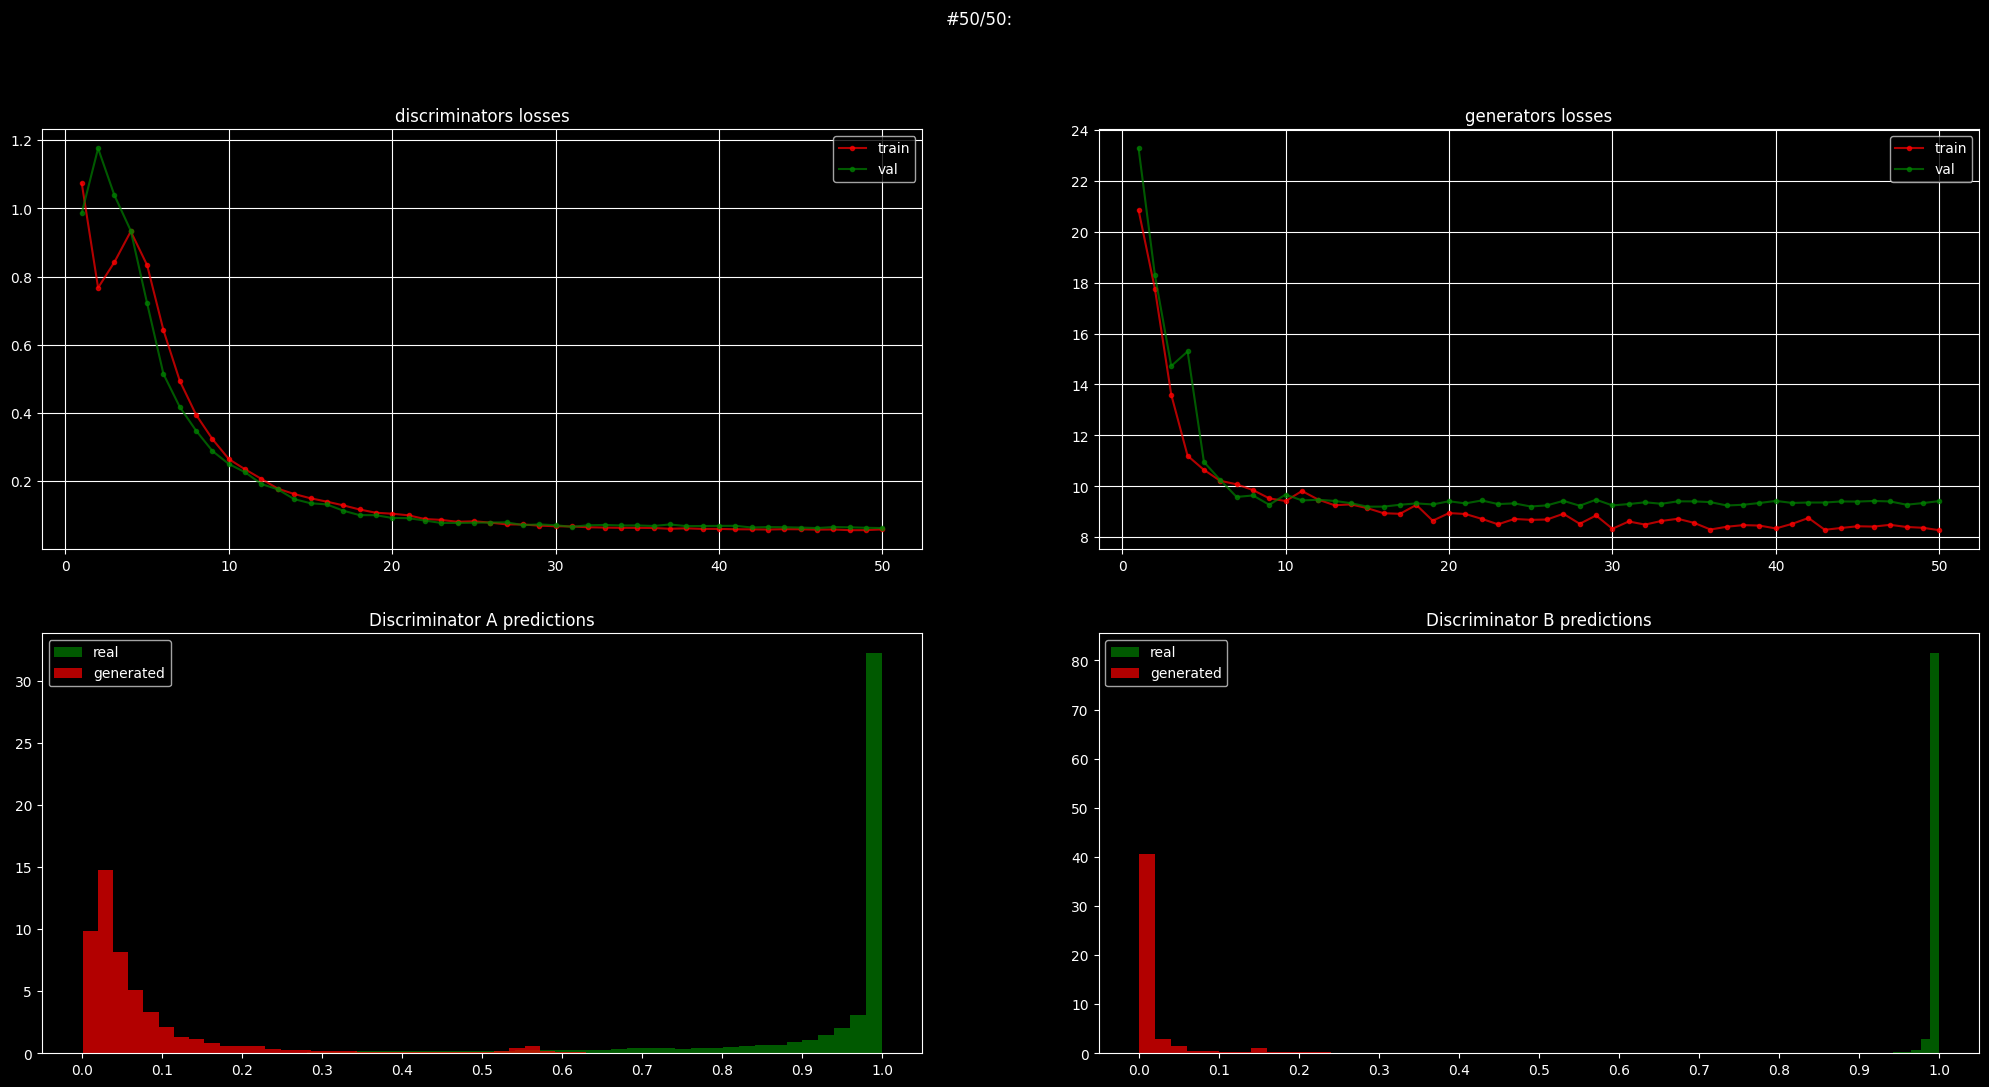

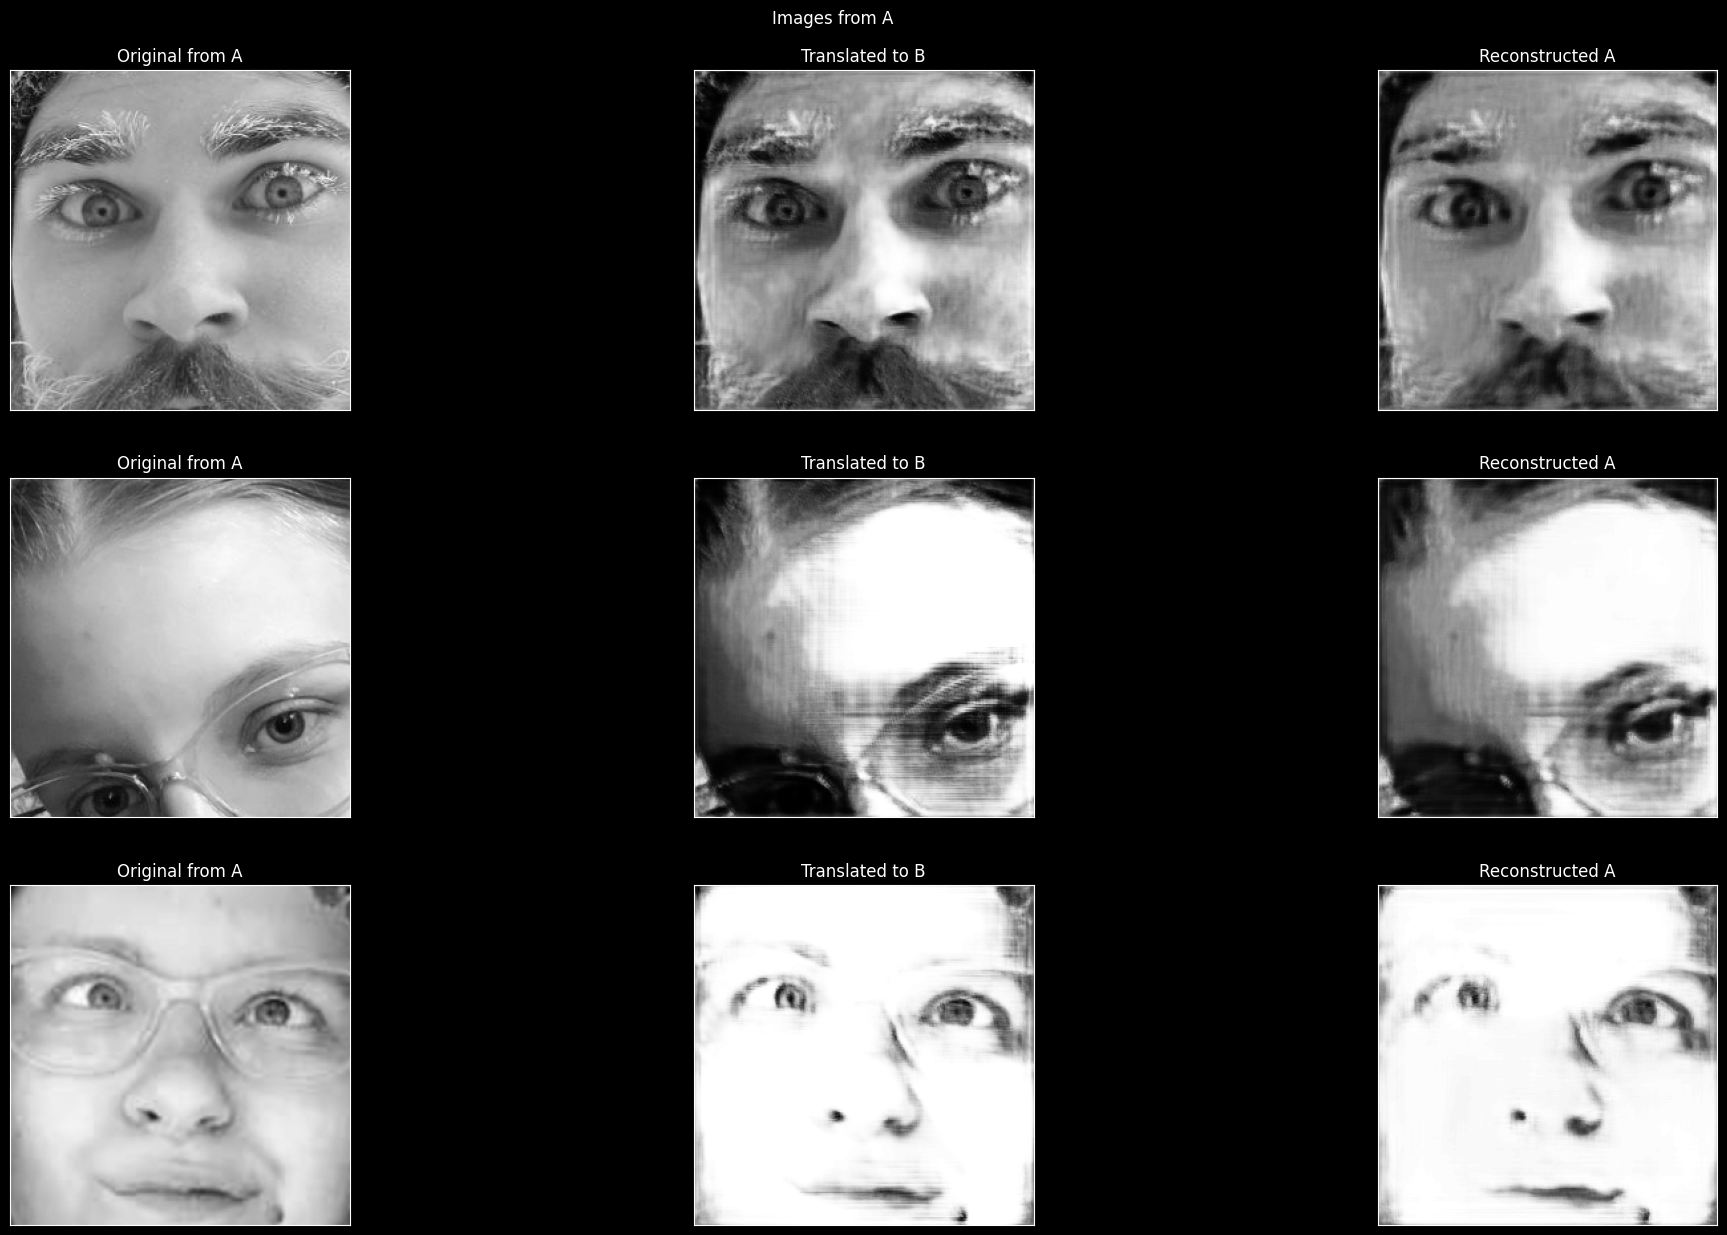

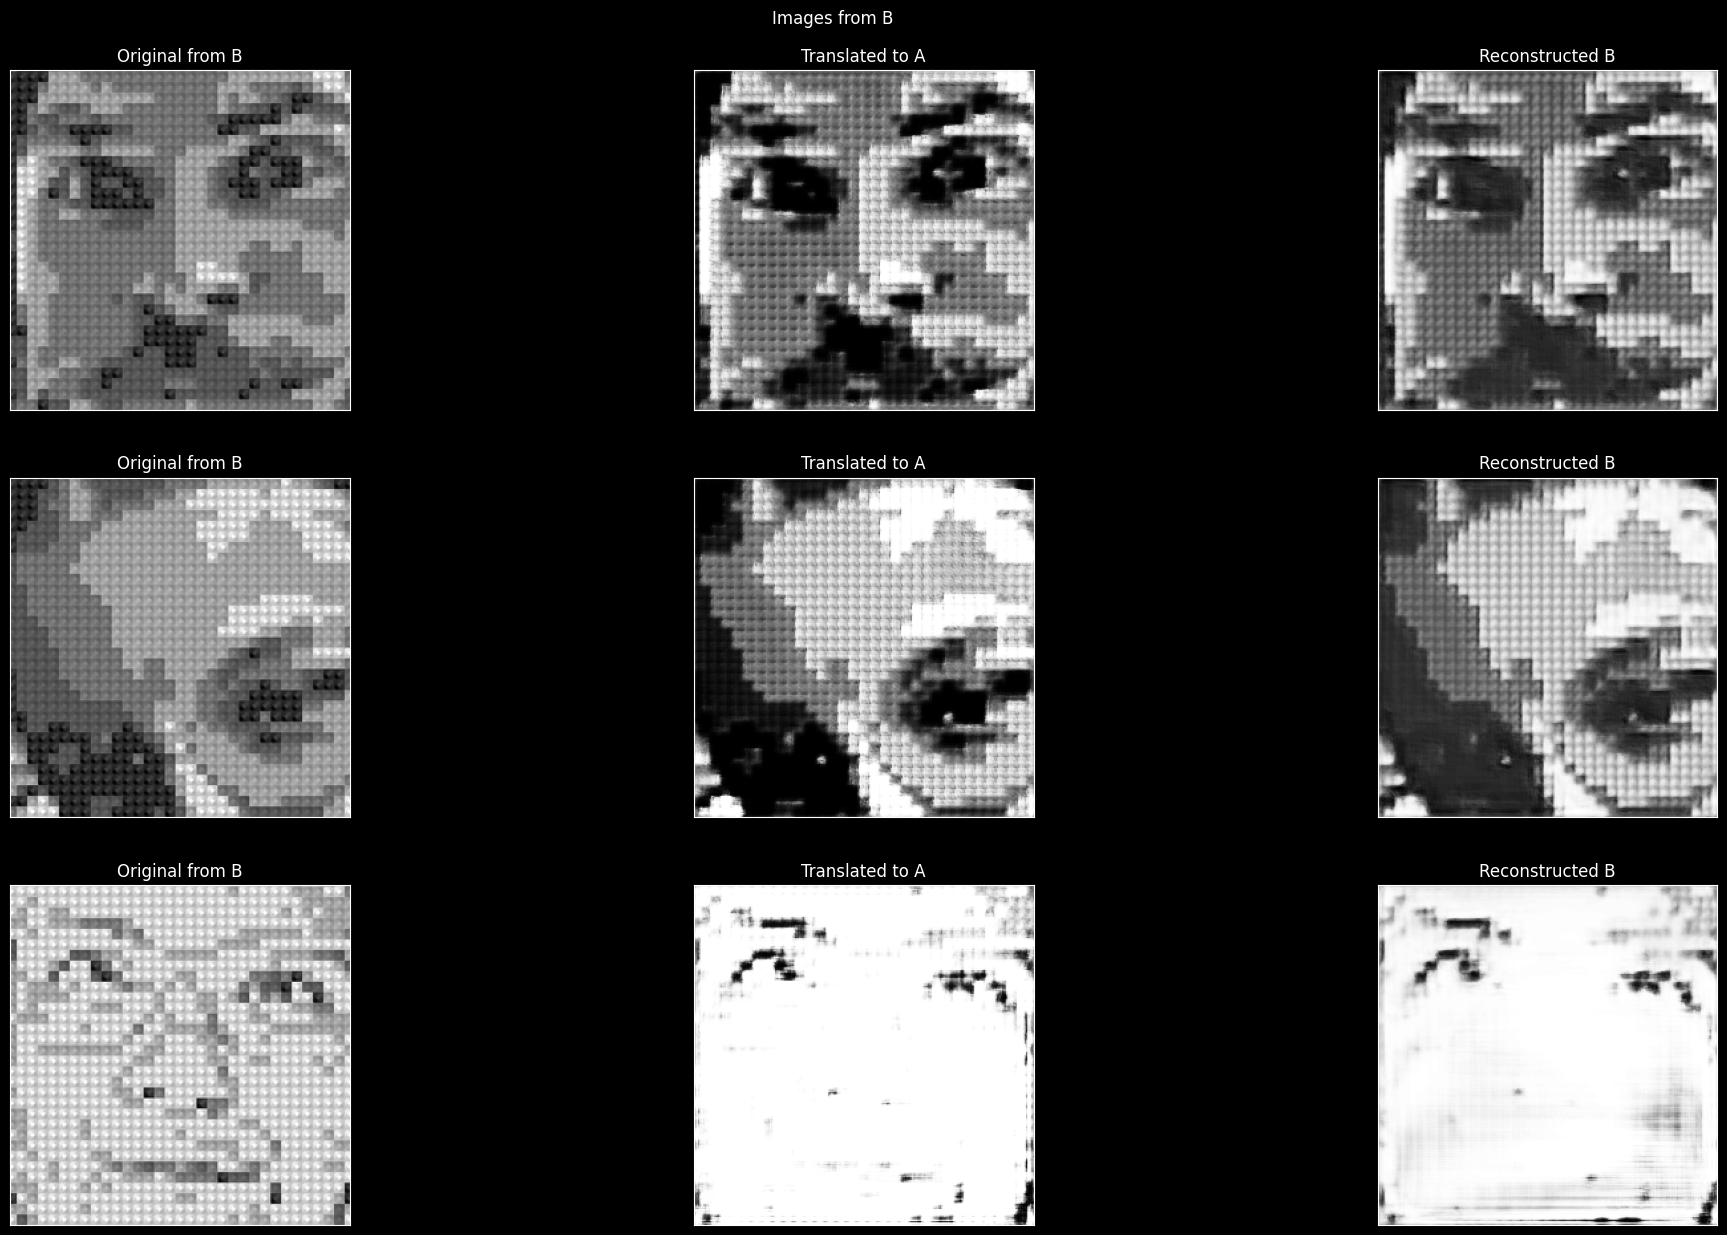

CPU times: user 7min 52s, sys: 1min 17s, total: 9min 10s
Wall time: 33min 41s


In [71]:
%%time
model, optimizer_d, optimizer_g, plots = learning_loop(
    model = model,
    optimizer_g = optimizer_g,
    g_iters_per_epoch = 1,
    optimizer_d = optimizer_d,
    d_iters_per_epoch = 1,
    train_loader_a = dataloaders.train_a,
    train_loader_b = dataloaders.train_b,
    val_loader_a = dataloaders.test_a,
    val_loader_b = dataloaders.test_b,
    criterion_d = criterion_d,
    criterion_g = criterion_g,
    scheduler_g = scheduler_g,
    scheduler_d = scheduler_d,
    de_norm_a = de_normalize_a,
    de_norm_b = de_normalize_b,
    epochs = 50,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 5,
    chkp_folder = "chkp",
    model_name = "cycle_gan_diamond",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
)

(256, 256, 1)


TypeError: Invalid shape (1, 256, 256) for image data

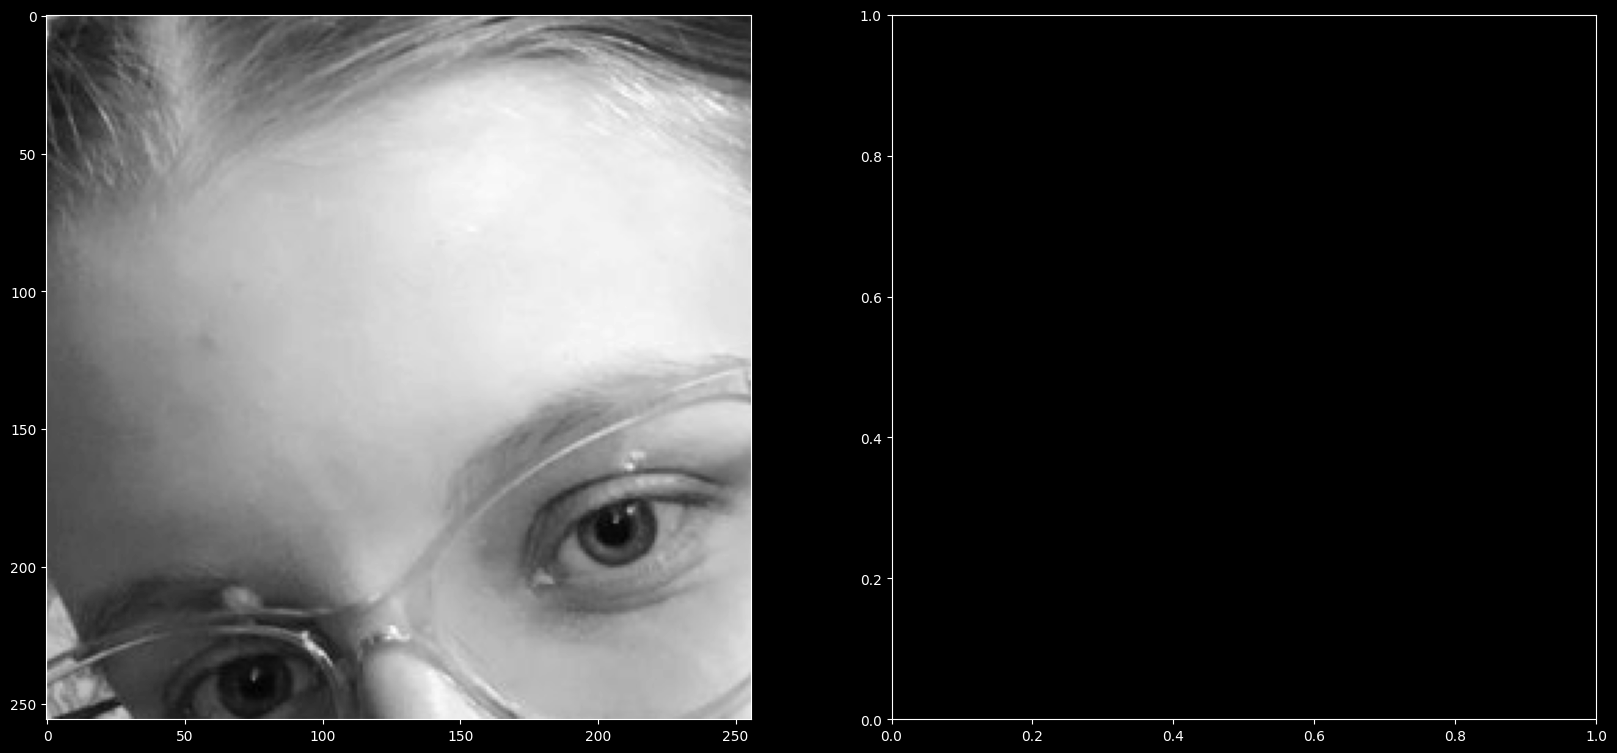

In [88]:
img_a = ds.test_a[1].to(device).unsqueeze(0)

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_a(img_a[0]), cmap='gray')
print()
plt.subplot(122)
plt.imshow(model.generator_a2b(img_a)[0].cpu().detach().numpy(), cmap='gray')

plt.show()

In [ ]:
img_a = ds.test_a[5].to(device).unsqueeze(0)

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_a(img_a[0]))

plt.subplot(122)
plt.imshow(de_normalize_b(model.generators_a2b(img_a)[0]))

plt.show()

In [ ]:
img_ind = 1student
img_a = ds.test_a[img_ind].to(device).unsqueeze(0)
fake_b = ...(img_a)...

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_a(img_a[0]))

plt.subplot(122)
plt.imshow(de_normalize_b(fake_b))

plt.show()

In [ ]:
img_ind = 0
img_b = ds.test_b[img_ind].to(device).unsqueeze(0)
fake_a = ...(img_b)...

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_b(img_b[0]))

plt.subplot(122)
plt.imshow(de_normalize_a(fake_a))

plt.show()